# Building an AI-powered multimodal RAG system with Docling and Granite

*Using IBM Granite vision, text-based embeddings and generative AI models*

## Multimodal retrieval-augmented generation

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. Popular multimodal LLMs include Google’s Gemini, Meta’s Llama 3.2 and OpenAI’s GPT-4 and GPT-4o. 

For this recipe, you will use an IBM Granite model capable of processing different modalities. You will create an AI system to answer real-time user queries from unstructured data in a PDF.

## Recipe overview

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of advanced tools to build an AI-powered multimodal RAG pipeline. This tutorial will guide you through the following processes:

- **Document preprocessing:** Learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

This recipe uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art LLM that provides robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Use RAG to perform efficient and accurate data retrieval for real-world applications.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.


## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Ensure you are running Python 3.10, 3.11 or 3.12 in a freshly created virtual environment.

In [12]:
import sys
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), "Use Python 3.10, 3.11, or 3.12 to run this notebook."

## Step 2: Install dependencies

In [13]:
%%capture
!pip install -q --progress-bar on "git+https://github.com/ibm-granite-community/utils.git" \
    transformers \
    pillow \
    langchain_community \
    langchain_huggingface \
    langchain_milvus \
    docling

In [14]:
!pip install PyPDF2
!pip install pymupdf
!pip install frontend

  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
  Using cached pymupdf-1.25.5-cp39-abi3-macosx_11_0_arm64.whl.metadata (3.4 kB)
Using cached pymupdf-1.25.5-cp39-abi3-macosx_11_0_arm64.whl (18.6 MB)
  Using cached frontend-0.0.3-py3-none-any.whl.metadata (847 bytes)
  Using cached starlette-0.46.2-py3-none-any.whl.metadata (6.2 kB)
  Using cached uvicorn-0.34.2-py3-none-any.whl.metadata (6.5 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
Using cached frontend-0.0.3-py3-none-any.whl (32 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached starlette-0.46.2-py3-none-any.whl (72 kB)
Using cached uvicorn-0.34.2-py3-none-any.whl (62 kB)
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [frontend]


## Step 3: Selecting the AI models

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [15]:
import logging
logging.basicConfig(level=logging.INFO)

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

## Step 4: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [16]:
import io
import re
import fitz                   # pip install pymupdf
from PyPDF2 import PdfReader, PdfWriter
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat, DocumentStream
from docling.datamodel.pipeline_options import PdfPipelineOptions

# ----------------------------------------
# 1) CLI filter patterns
# ----------------------------------------
PROMPT_RX = re.compile(r'^[\w\-\./]+@[\w\-\./]+[>%#]\s+.+')  
CONFIG_RX = re.compile(r'^\s*(?:set|delete|show|request|clear|commit|rollback)\s+.+', re.IGNORECASE)

def is_cli(text: str) -> bool:
    """Return True if the span text looks like a CLI command."""
    t = text.strip()
    return bool(PROMPT_RX.match(t) or CONFIG_RX.match(t))

# ----------------------------------------
# 2) Function to extract colored CLI spans
# ----------------------------------------
def extract_colored_cli_spans(pdf_bytes: bytes):
    """
    Returns a list of dicts: each with page number, CLI text, RGB color, and bbox,
    but only for spans matching typical CLI patterns.
    """
    doc = fitz.open(stream=pdf_bytes, filetype="pdf")
    cli_spans = []
    for page_idx, page in enumerate(doc, start=1):
        for block in page.get_text("dict")["blocks"]:
            if block["type"] != 0:
                continue  # skip images/graphics
            for line in block["lines"]:
                for span in line["spans"]:
                    text = span["text"]
                    if not is_cli(text):
                        continue
                    c = span.get("color", 0)
                    r, g, b = (c >> 16 & 0xFF, c >> 8 & 0xFF, c & 0xFF)
                    cli_spans.append({
                        "page": page_idx,
                        "cli": text.strip(),
                        "color": (r, g, b),
                        "bbox": span["bbox"],
                    })
    doc.close()
    return cli_spans

# ----------------------------------------
# 3) Read the PDF & write all pages into memory
# ----------------------------------------
local_pdf_path = "CSR-ACX7024-configuration-guide-v1.1.pdf"

with open(local_pdf_path, "rb") as f_in:
    reader = PdfReader(f_in)
    writer = PdfWriter()
    for page in reader.pages:
        writer.add_page(page)
    pdf_bytes_io = io.BytesIO()
    writer.write(pdf_bytes_io)

pdf_bytes = pdf_bytes_io.getvalue()

# ----------------------------------------
# 4) Save the OCR’d PDF to disk
# ----------------------------------------
with open("CSR-ACX7024-configuration-guide-v1.1_ocr.pdf", "wb") as f_out:
    f_out.write(pdf_bytes)
    print("✅ Saved OCR PDF as CSR-ACX7024-configuration-guide-v1.1_ocr.pdf")

# ----------------------------------------
# 5) Extract only CLI-colored spans
# ----------------------------------------
cli_spans = extract_colored_cli_spans(pdf_bytes)

# Print CLI spans with color
for span in cli_spans:
    print(f"Page {span['page']}: {span['cli']}  → color {span['color']}")

# ----------------------------------------
# 6) Run your original DocumentConverter pipeline
# ----------------------------------------
stream_for_converter = io.BytesIO(pdf_bytes)
document_stream = DocumentStream(
    name="CSR-ACX7024-configuration-guide-v1.1.pdf",
    stream=stream_for_converter,
    input_format=InputFormat.PDF
)

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}

converter = DocumentConverter(format_options=format_options)
converted_document = converter.convert(source=document_stream).document

# Now `converted_document` is unchanged, and `cli_spans` holds all CLI commands
# with their original PDF color for downstream use.

/Users/denizaskin/telus-incident-mgmt-copilot/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Saved OCR PDF as CSR-ACX7024-configuration-guide-v1.1_ocr.pdf


INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for StandardPdfPipeline with options hash 3e036157fb20985f12804535c7dd1f2d
INFO:docling.models.factories.base_factory:Loading plugin 'docling_defaults'
INFO:docling.models.factories:Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'


Page 28: set class-of-service interfaces ge-x/y/z shaping-rate 300m  → color (0, 0, 0)
Page 33: set class-of-service interfaces  → color (0, 0, 0)
Page 70: delete chassis auto-image-upgrade  → color (0, 0, 0)
Page 70: delete system commit factory-settings  → color (0, 0, 0)
Page 70: set system root-authentication encrypted-password  → color (0, 0, 0)
Page 70: set system login user  → color (0, 0, 0)
Page 70: set system login user  → color (0, 0, 0)
Page 70: set system login class  → color (0, 0, 0)
Page 70: set system login class  → color (0, 0, 0)
Page 70: set system login class  → color (0, 0, 0)
Page 70: set system login class  → color (0, 0, 0)
Page 70: set system login user  → color (0, 0, 0)
Page 70: set system login user  → color (0, 0, 0)
Page 70: set system login user  → color (0, 0, 0)
Page 70: set system ports console log-out-on-disconnect  → color (0, 0, 0)
Page 71: set system ports console type vt100  → color (0, 0, 0)
Page 71: delete interfaces lo0 unit 0  → color (0, 0, 

INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.models.factories.base_factory:Loading plugin 'docling_defaults'
INFO:docling.models.factories:Registered picture descriptions: ['vlm', 'api']
INFO:docling.pipeline.base_pipeline:Processing document CSR-ACX7024-configuration-guide-v1.1.pdf


KeyboardInterrupt: 

In [92]:
import fitz  # pip install pymupdf
import re

# ----------------------------------------
# 1) Save the PDF as plain text
# ----------------------------------------
def save_pdf_as_txt(pdf_path: str, txt_path: str):
    """
    Dumps all pages of the PDF to a single .txt file.
    """
    doc = fitz.open(pdf_path)
    with open(txt_path, "w", encoding="utf-8") as out:
        for page in doc:
            out.write(page.get_text())
            out.write("\f")  # form-feed between pages
    doc.close()

# ----------------------------------------
# 2) Extract CLI lines from the text file
# ----------------------------------------
PROMPT_RX = re.compile(r'^[\w\-\./]+@[\w\-\./]+[>%#]\s+.+')  
CONFIG_RX = re.compile(r'^\s{2,}(?:set|delete|show|request|clear|commit|rollback)\s+.+', re.IGNORECASE)

def extract_clis(txt_path: str) -> list[str]:
    """
    Returns a deduplicated list of CLI commands found in the .txt.
    """
    clis = []
    with open(txt_path, encoding='utf-8') as f:
        for raw in f:
            line = raw.rstrip()
            if not (PROMPT_RX.match(line) or CONFIG_RX.match(line)):
                continue
            stripped = line.strip()
            if len(stripped) > 200 or ' ' not in stripped:
                continue
            clis.append(stripped)

    seen = set()
    unique = []
    for cmd in clis:
        if cmd not in seen:
            seen.add(cmd)
            unique.append(cmd)
    return unique

# ----------------------------------------
# 3) Main execution
# ----------------------------------------
if __name__ == "__main__":
    pdf_path = "CSR-ACX7024-configuration-guide-v1.1.pdf"
    txt_path = "CSR-ACX7024-configuration-guide-v1.1.txt"

    # Convert PDF to text
    save_pdf_as_txt(pdf_path, txt_path)
    print(f"✅ Saved text version as {txt_path}")

    # Extract and print CLI commands
    commands = extract_clis(txt_path)
    print("Extracted CLI Commands:")
    for cmd in commands:
        print(cmd)

✅ Saved text version as CSR-ACX7024-configuration-guide-v1.1.txt
Extracted CLI Commands:
user@host> request system shutdown reboot usb
lab@SRBHONTFUC71> scp lab@<jumpbox-ip:/path/junos-evo-install-acx-f-x86-64-22.4R2-S1.8-EVO.iso
lab@UC-ACX> file checksum md5 /var/tmp/junos-evo-install-acx-f-x86-64-22.4R2-S1.8-EVO.iso
lab@SRBHONTFUC71> request system software add /var/tmp/junos-evo-install-acx-f-x86-64-22.4R2-
lab@SRBHONTFUC71> show system software list
lab@SRBHONTFUC71> request system software ?
delete               Remove extension or upgrade package
rollback             Attempt to roll back to previous set of packages
lab@SRBHONTFUC71> show chassis pic fpc-slot 0 pic-slot 0
lab@SRBHONTFUC71> show firewall filter ?


In [93]:
from pprint import pprint

# Convert the entire document to a dict
doc_dict = converted_document.model_dump()

# Option 1: Print first 3 top-level keys (if it's deeply nested)
print("Top-level structure (truncated):")
for key in list(doc_dict.keys())[:6]:
    print(f"{key}:")
    pprint(doc_dict[key])
    print()

# Option 2: If you want just a few content blocks:
if "content_blocks" in doc_dict:
    print("First few content blocks:")
    for i, block in enumerate(doc_dict["content_blocks"][:5]):
        print(f"\n--- Block {i} ---")
        pprint(block)

Top-level structure (truncated):
schema_name:
'DoclingDocument'

version:
'1.3.0'

name:
'CSR-ACX7024-configuration-guide-v1.1'

origin:
{'binary_hash': 9288112787181933168,
 'filename': 'CSR-ACX7024-configuration-guide-v1.1.pdf',
 'mimetype': 'application/pdf',
 'uri': None}

furniture:
{'children': [],
 'content_layer': <ContentLayer.FURNITURE: 'furniture'>,
 'label': <GroupLabel.UNSPECIFIED: 'unspecified'>,
 'name': '_root_',
 'parent': None,
 'self_ref': '#/furniture'}

body:
{'children': [{'cref': '#/pictures/0'},
              {'cref': '#/texts/0'},
              {'cref': '#/texts/1'},
              {'cref': '#/texts/2'},
              {'cref': '#/texts/3'},
              {'cref': '#/texts/4'},
              {'cref': '#/texts/5'},
              {'cref': '#/texts/6'},
              {'cref': '#/texts/7'},
              {'cref': '#/texts/8'},
              {'cref': '#/texts/9'},
              {'cref': '#/texts/10'},
              {'cref': '#/tables/0'},
              {'cref': '#/tex

In [108]:
from transformers import GPT2TokenizerFast
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

# Initialize tokenizer
embeddings_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
max_tokens = embeddings_tokenizer.model_max_length  # 1024

# Configure chunker to respect token limit
chunker = HybridChunker(
    tokenizer=embeddings_tokenizer,
    chunk_size=max_tokens,
    chunk_overlap=20,
)

doc_id = 0
texts: list[Document] = []

for chunk in chunker.chunk(converted_document):
    items = chunk.meta.doc_items
    if len(items) == 1 and isinstance(items[0], TableItem):
        continue

    # Provenance refs
    refs = " ".join(item.get_ref().cref for item in items)
    raw_text = chunk.text

    # Manually truncate tokens as a safety net
    tokens = embeddings_tokenizer.encode(raw_text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]

    safe_text = embeddings_tokenizer.decode(tokens, skip_special_tokens=True)

    document = Document(
        page_content=safe_text,
        metadata={
            "doc_id": (doc_id := doc_id + 1),
            "source": "CSR-ACX7024-configuration-guide-v1.1.pdf",
            "ref": refs,
        },
    )
    texts.append(document)

print(f"{len(texts)} text document chunks created")

Token indices sequence length is longer than the specified maximum sequence length for this model (2010 > 1024). Running this sequence through the model will result in indexing errors


221 text document chunks created


With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [109]:
from docling_core.types.doc.labels import DocItemLabel

# Continue document IDs from previous text documents
doc_id = len(texts)
tables: list[Document] = []

# Process tables from previously converted_document
for table in converted_document.tables:
    if table.label == DocItemLabel.TABLE:
        ref = table.get_ref().cref
        print(ref)

        # ✅ Pass the full document as `doc` to avoid deprecation warning
        text = table.export_to_markdown(doc=converted_document)

        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id := doc_id + 1),
                "source": "CSR-ACX7024-configuration-guide-v1.1.pdf",
                "ref": ref,
            },
        )
        tables.append(document)

print(f"{len(tables)} table documents created")

#/tables/0
#/tables/1
#/tables/2
#/tables/7
#/tables/8
#/tables/9
#/tables/10
#/tables/11
#/tables/12
#/tables/13
#/tables/14
#/tables/15
#/tables/16
#/tables/17
#/tables/18
#/tables/19
#/tables/20
#/tables/21
#/tables/22
#/tables/23
#/tables/24
#/tables/25
#/tables/26
#/tables/27
#/tables/28
#/tables/29
#/tables/30
#/tables/31
#/tables/32
#/tables/33
#/tables/34
#/tables/35
#/tables/36
#/tables/37
#/tables/38
#/tables/39
#/tables/40
#/tables/41
#/tables/42
#/tables/43
40 table documents created


In [110]:
print(tables[2].page_content)

| Reviewers       | Function/Group   | Date   |
|-----------------|------------------|--------|
| Group Reviewers | MPLS DATA/IP     |        |


Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [111]:
import os
os.environ['WATSONX_API_KEY'] = "c5jsf7CBqlU_kPW8Hj80VnU13RX2ezGPTs6Fyg0-1s3A"
os.environ['WATSONX_PROJECT_ID'] = "d3d3c03e-2dd6-4892-b7d7-139c5dc8a1d0"

API_KEY="c5jsf7CBqlU_kPW8Hj80VnU13RX2ezGPTs6Fyg0-1s3A"
URL="https://us-south.ml.cloud.ibm.com/"
PROJECT_ID="d3d3c03e-2dd6-4892-b7d7-139c5dc8a1d0"

In [98]:
from PIL import Image
from io import BytesIO
import base64
import requests
from langchain.schema import Document

def get_iam_access_token(api_key: str) -> str:
    iam_url = "https://iam.cloud.ibm.com/identity/token"
    response = requests.post(
        iam_url,
        data={
            "apikey": api_key,
            "grant_type": "urn:ibm:params:oauth:grant-type:apikey"
        },
        headers={"Content-Type": "application/x-www-form-urlencoded"}
    )
    response.raise_for_status()
    return response.json()["access_token"]


# Set up Watsonx info
access_token = get_iam_access_token("c5jsf7CBqlU_kPW8Hj80VnU13RX2ezGPTs6Fyg0-1s3A")
project_id = "d3d3c03e-2dd6-4892-b7d7-139c5dc8a1d0"
model_id = "meta-llama/llama-3-2-90b-vision-instruct"

# Start image processing
doc_id = len(texts) + len(tables)
pictures: list[Document] = []

body_refs = converted_document.body.children
print(f"\nGenerating image descriptions for {len(converted_document.pictures)} pictures...")

for i, ref in enumerate(body_refs):
    if not ref.cref.startswith("#/pictures/"):
        continue

    print(f"\nProcessing image {i + 1}")

    picture_index = int(ref.cref.split("/")[-1])
    picture = converted_document.pictures[picture_index]
    image = picture.get_image(converted_document)

    if not image:
        print("Skipping: Image not found.")
        continue

    try:
        image.thumbnail((1024, 1024), Image.Resampling.LANCZOS)
        if image.mode in ("RGBA", "LA"):
            image = image.convert("RGB")

        buffered = BytesIO()
        image.save(buffered, format="JPEG", quality=70)
        image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print("Failed to process image:", e)
        continue

    # Get context text
    above_text = below_text = ""
    if i > 0 and body_refs[i - 1].cref.startswith("#/texts/"):
        idx = int(body_refs[i - 1].cref.split("/")[-1])
        above_text = converted_document.texts[idx].text.strip()
    if i < len(body_refs) - 1 and body_refs[i + 1].cref.startswith("#/texts/"):
        idx = int(body_refs[i + 1].cref.split("/")[-1])
        below_text = converted_document.texts[idx].text.strip()

    context_text = f"Text above the image:\n{above_text}\n\nText below the image:\n{below_text}"

    # Watsonx API payload
    body = {
        "messages": [
            {
                "role": "system",
                "content": (
                    "You always respond strictly in JSON format matching this schema:\n\n"
                    "{\n"
                    "  \"images\": [\n"
                    "    {\n"
                    "      \"image_id\": \"\",\n"
                    "      \"title\": \"\",\n"
                    "      \"type\": \"\",\n"
                    "      \"page_reference\": \"\",\n"
                    "      \"revision_or_version\": \"\",\n"
                    "      \"author_or_source\": \"\",\n"
                    "      \"creation_or_issue_date\": \"\",\n"
                    "      \"description\": \"\",\n"
                    "      \"diagram_elements\": [\n"
                    "        {\n"
                    "          \"element_name\": \"\",\n"
                    "          \"element_type\": \"\",\n"
                    "          \"properties\": {\n"
                    "            \"dimensions\": \"\",\n"
                    "            \"power_specs\": \"\",\n"
                    "            \"ports_or_interfaces\": [],\n"
                    "            \"ip_addresses\": [],\n"
                    "            \"protocols\": [],\n"
                    "            \"vlan_tags\": [],\n"
                    "            \"roles\": [],\n"
                    "            \"other_details\": \"\"\n"
                    "          }\n"
                    "        }\n"
                    "      ],\n"
                    "      \"connections_or_relationships\": [\n"
                    "        {\n"
                    "          \"from_element\": \"\",\n"
                    "          \"to_element\": \"\",\n"
                    "          \"link_type\": \"\",\n"
                    "          \"bandwidth_or_speed\": \"\",\n"
                    "          \"notes\": \"\"\n"
                    "        }\n"
                    "      ],\n"
                    "      \"purpose_or_scenario\": \"\",\n"
                    "      \"associated_vr_or_network_context\": [],\n"
                    "      \"relevant_configuration_details\": [],\n"
                    "      \"notes_and_annotations\": \"\"\n"
                    "    }\n"
                    "  ]\n"
                    "}\n\n"
                    "Only return valid JSON output that strictly follows this structure. Omit all explanations or extra text."
                )
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"Describe the image below using the surrounding context. If it contains CLIs (JUNOS OS Command Lines), make sure to capture the CLIs in the JSON description field \n\n{context_text}"},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]
            }
        ],
        "project_id": project_id,
        "model_id": model_id,
        "max_tokens": 2500,
        "temperature": 0.7,
        "top_p": 1
    }

    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json",
        "Authorization": f"Bearer {access_token}"
    }

    url = "https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2023-05-29"

    try:
        response = requests.post(url, headers=headers, json=body, timeout=300)
        response.raise_for_status()
        data = response.json()
        generated_text = data.get("choices", [{}])[0].get("message", {}).get("content", "")
    except Exception as e:
        print(f"Error during request or parsing: {e}")
        generated_text = "[Image description unavailable due to error.]"

    doc_id += 1
    document = Document(
        page_content=generated_text,
        metadata={
            "doc_id": doc_id,
            "source": "IBM_COS/document_from_cos.pdf",
            "ref": ref.cref,
            "type": "picture",
            "image_base64": image_base64
        },
    )
    pictures.append(document)

print(f"\n{len(pictures)} image descriptions created.")


Generating image descriptions for 64 pictures...

Processing image 1

Processing image 62

Processing image 65

Processing image 72

Processing image 73

Processing image 74


KeyboardInterrupt: 

In [112]:
# -----------------------------------------------------------
# Build a Markdown file that preserves original PDF ordering
# -----------------------------------------------------------

import os
from pathlib import Path

def export_pdf_to_markdown(
    converted_document,
    pictures_docs,
    output_md_path: str | os.PathLike = "converted_document_CLI.md",
):
    """
    Create a Markdown file that interleaves
      • plain text blocks
      • table markdown
      • inline image embeds + their JSON descriptions
    in **exactly** the order the objects appear in the PDF.
    Images are embedded as base‑64 so the .md is self‑contained.
    """
    # Quick look‑up for pictures by their cref (stored earlier in metadata["ref"])
    picture_lookup = {doc.metadata["ref"]: doc for doc in pictures_docs}

    body_refs = converted_document.body.children
    out_path = Path(output_md_path).expanduser().resolve()

    with out_path.open("w", encoding="utf-8") as md:
        for ref in body_refs:
            cref = ref.cref

            # ------------ TEXT ------------
            if cref.startswith("#/texts/"):
                idx = int(cref.split("/")[-1])
                md.write(converted_document.texts[idx].text.strip() + "\n\n")

            # ------------ TABLE ------------
            elif cref.startswith("#/tables/"):
                idx = int(cref.split("/")[-1])
                table_md = converted_document.tables[idx].export_to_markdown(
                    doc=converted_document
                )
                md.write(table_md.strip() + "\n\n")

            # ------------ PICTURE ------------
            elif cref.startswith("#/pictures/"):
                pic_doc = picture_lookup.get(cref)
                if not pic_doc:
                    continue  # safety check

                # Inline the picture (base‑64)
                img_b64 = pic_doc.metadata.get("image_base64", "")
                if img_b64:
                    md.write(f"![image]("
                             f"data:image/jpeg;base64,{img_b64}"
                             f")\n\n")

                # Followed by the JSON description
                md.write("```json\n")
                md.write(pic_doc.page_content.strip() + "\n")
                md.write("```\n\n")

    print(f"✅ Markdown saved to: {out_path}")

# -----------------------------------------------------------------
# Run it – generates converted_document.md alongside the notebook
# -----------------------------------------------------------------
export_pdf_to_markdown(converted_document, pictures, "converted_document.md")

✅ Markdown saved to: /Users/denizaskin/telus-incident-mgmt-copilot/notebooks/wxO_api/converted_document.md


Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image. You might want to experiment with different prompt text to see how it might improve the results.

NOTE: Processing the images can take a very long time depending upon the number of images and the service running the vision language model.

We can then display the LangChain documents created from the input documents.

## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database can take some time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

Document ID: 1
Source: CSR-ACX7024-configuration-guide-v1.1.pdf
Content:
Title:
Document ID: 2
Source: CSR-ACX7024-configuration-guide-v1.1.pdf
Content:
Abstract: This  document  presents  the  technical  description  of  software configuration  on  Juniper  ACX7024  CSR  and  to  be  deployed  on  TELUS Mobility RAN IP backhaul project.
Author
Ricky Ip
Last Revised Date
January 11, 2024
Issue
1.1
The  information  herein  is  TELUS  Communications  Inc.  confidential  and  proprietary.    Any review, distribution or other use of this information outside of one's scope of employment with TELUS is strictly prohibited.  TELUS Communications Inc. will avail itself of all legal rights and remedies in protecting the confidentiality, property rights, and use of the information.  If you are not a TELUS  employee  and  have  this  information  please  call 1-877-333-8888 immediately.
Document ID: 3
Source: CSR-ACX7024-configuration-guide-v1.1.pdf
Content:
1.0, Issue Date = October 31, 2023. 1.

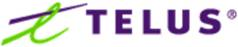

Document ID: 263
Source: IBM_COS/document_from_cos.pdf
Description:
{
  "images": [
    {
      "image_id": "RouterConsolePort",
      "title": "Router Console Port Diagram",
      "type": "Router Diagram",
      "page_reference": "Juniper Networks Documentation",
      "revision_or_version": "Revision 1",
      "author_or_source": "Juniper Networks",
      "creation_or_issue_date": "2022-01-01",
      "description": "A diagram showing the console port of an ACX7024 router with an RJ-45 connector and an RJ-45 to DB-9 rollover cable connected to a Terminal Server Console port.",
      "diagram_elements": [
        {
          "element_name": "Router Console Port",
          "element_type": "Router Port",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": ["RJ-45"],
            "ip_addresses": [],
            "protocols": [],
            "vlan_tags": [],
            "roles": ["Console Port"],
            "other_detail

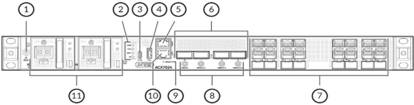

Document ID: 264
Source: IBM_COS/document_from_cos.pdf
Description:
{
  "images": [
    {
      "image_id": "1",
      "title": "Cooling Fans",
      "type": "Schematic",
      "page_reference": "",
      "revision_or_version": "",
      "author_or_source": "",
      "creation_or_issue_date": "",
      "description": "A diagram showing a series of cooling fans, with a note indicating they are not field replaceable.",
      "diagram_elements": [
        {
          "element_name": "Cooling Fans",
          "element_type": "Mechanical Component",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": [],
            "ip_addresses": [],
            "protocols": [],
            "vlan_tags": [],
            "roles": [],
            "other_details": "Not field replaceable"
          }
        }
      ],
      "connections_or_relationships": [],
      "purpose_or_scenario": "Illustration of cooling fans in a system",
      "as

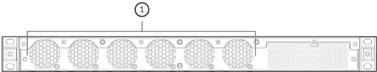

Document ID: 265
Source: IBM_COS/document_from_cos.pdf
Description:
{
  "images": [
    {
      "image_id": "",
      "title": "Power Spec",
      "type": "Line Drawing",
      "page_reference": "",
      "revision_or_version": "",
      "author_or_source": "",
      "creation_or_issue_date": "",
      "description": "Power Spec",
      "diagram_elements": [
        {
          "element_name": "AC Inlet",
          "element_type": "Power Port",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": [],
            "ip_addresses": [],
            "protocols": [],
            "vlan_tags": [],
            "roles": [],
            "other_details": ""
          }
        },
        {
          "element_name": "Latch Lever",
          "element_type": "Mechanical Component",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": [],
            "ip_addresses": 

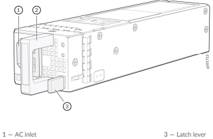

Document ID: 266
Source: IBM_COS/document_from_cos.pdf
Description:
{
  "images": [
    {
      "image_id": "",
      "title": "PSM",
      "type": "diagram",
      "page_reference": "",
      "revision_or_version": "",
      "author_or_source": "",
      "creation_or_issue_date": "",
      "description": "The PSM is monitoring no inter power.",
      "diagram_elements": [
        {
          "element_name": "PSM",
          "element_type": "box",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": [],
            "ip_addresses": [],
            "protocols": [],
            "vlan_tags": [],
            "roles": [],
            "other_details": ""
          }
        }
      ],
      "connections_or_relationships": [],
      "purpose_or_scenario": "PSM deployment scenario",
      "associated_vr_or_network_context": [],
      "relevant_configuration_details": [],
      "notes_and_annotations": ""
    }
  ]
}


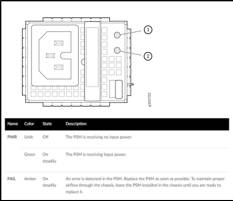

In [113]:
import base64
from io import BytesIO
from PIL import Image
from langchain.schema import Document  # or langchain_core.documents.Document
import itertools

# Display text + table documents
for document in itertools.chain(texts, tables):
    if not isinstance(document, Document):
        continue

    print(f"Document ID: {document.metadata.get('doc_id')}")
    print(f"Source: {document.metadata.get('source')}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)

# Display picture documents (image from base64)
for document in pictures:
    if not isinstance(document, Document):
        continue

    print(f"Document ID: {document.metadata.get('doc_id')}")
    print(f"Source: {document.metadata.get('source')}")
    print(f"Description:\n{document.page_content}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            display(image)  # or image.show() if not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No image found in metadata.")

    print("=" * 80)


In [114]:
import tempfile
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

# Use lightweight embedding model
embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create temporary vector DB file
db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

# Initialize Milvus vector store
vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


The vector database will be saved to /var/folders/1t/7cjrsy2949n9nwlmm_7d_c6c0000gn/T/vectorstore_cx6oh9dt.db


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Uncomment for ElasticSearch
# from langchain.embeddings import HuggingFaceEmbeddings
# from langchain_community.vectorstores import ElasticsearchStore
# from elasticsearch import Elasticsearch
# import urllib3

# # Disable SSL warnings and verification
# urllib3.disable_warnings()

# # Create Elasticsearch client with verification disabled
# es_client = Elasticsearch(
#     "https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220",
#     basic_auth=("ibm_cloud_122bb980_f9d4_4f16_b969_962981afc29a", "IeQpyaxYSY6MjA96eo4g0FYUq4p7YZlS"),
#     verify_certs=False
# )

# # Embedding model
# embeddings_model = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

# # Initialize ElasticsearchStore with es_connection
# vector_db = ElasticsearchStore(
#     es_connection=es_client,  # Use this, not es_url
#     index_name="telus-index-csr-acx7024-configuration-guide-v1.1-mxbai-embed-large-v1",
#     embedding=embeddings_model,
# )

# print("Successfully connected to Elasticsearch with SSL verification disabled.")


/Users/denizaskin/telus-incident-mgmt-copilot/.venv/lib/python3.12/site-packages/elasticsearch/_sync/client/__init__.py:311: SecurityWarning: Connecting to 'https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220' using TLS with verify_certs=False is insecure
  _transport = transport_class(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: mixedbread-ai/mxbai-embed-large-v1
INFO:sentence_transformers.SentenceTransformer:2 prompts are loaded, with the keys: ['query', 'passage']


Successfully connected to Elasticsearch with SSL verification disabled.


/var/folders/1t/7cjrsy2949n9nwlmm_7d_c6c0000gn/T/ipykernel_56229/1435231236.py:20: LangChainPendingDeprecationWarning: The class `ElasticsearchStore` will be deprecated in a future version. Use :class:`~Use class in langchain-elasticsearch package` instead.
  vector_db = ElasticsearchStore(


We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [115]:
!pip install pytesseract


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [116]:
from langchain.schema import Document
import itertools

# Combine and filter valid Document instances
documents = [
    doc for doc in itertools.chain(texts, tables, pictures)
    if isinstance(doc, Document)
]

# Add to vector DB
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")


266 documents added to the vector database


## Step 5: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up out RAG pipeline.

### Retrieve relevant chunks



Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

Feel free to try different queries.

In [117]:
import base64
from io import BytesIO
from PIL import Image

query = "Give me the 'under UMTS/LTE combined Legacy' scenario"
results = vector_db.as_retriever().invoke(query)

for i, document in enumerate(results):
    print(f"\n Document {i + 1}")
    print(f"Content:\n{document.page_content}")
    #print(f"Metadata: {document.metadata}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            print("Displaying embedded image...")
            display(image)  # Use image.show() if you're not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No embedded image found in metadata.")

    print("=" * 80)



 Document 1
Content:
Under UMTS/LTE combined Legacy scenario, a shared uplink GE port is to be used to support both UMTS and 4G LTE traffic.
UMTS service configuration requirement:
-UMTS configuration under global routing layer (prior to Q3-2019)
-As from (Q3 - 2019) to be on its own VR
-a /32 IP loopback assigns from UMTS/HSPA Mgt IP block
-enable OSPF protocol  to form adjacency with UAs through GEMAN
-2x /30 WAN IP from UMTS IP block
-2x VLANs for uplink Red and Blue from UMTS vlan schema
-All UMTS Node B, MW, IP subnets assignment to be sourced from UMTS IP block
-* QoS policy and scheduler to be deployed under LTE, all sub/interfaces should reconfigure to use LTE QoS policy.
No embedded image found in metadata.

 Document 2
Content:
-LTE service VR, LTE OAM VR, IP alarm VR will be routed through 'Converge Edge'
-WAN uplink Scenario #1, 2, 3  will be applied according to access facility design, please refer to above 'WAN Scenario #1,2,3'
To support SamSung 4G/5G BBU in 2020 Q4, th

In [118]:
query = "CSR VR (VRF) instances design diagram"
i = 0

results = vector_db.as_retriever().invoke(query)

for i, document in enumerate(results):
    print(f"\nDocument {i + 1}")
    print(f"Content:\n{document.page_content}")
    #print(f"Metadata: {document.metadata}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            print("Displaying embedded image...")
            display(image)  # Use image.show() if you're not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No embedded image found in metadata.")

    print("=" * 80)



Document 1
Content:
Under current LTE IP RAN service design, CSR is to create multiple VRFs to separate management, and user traffic functionality. A typical CSR setup will be a HUB and Spoke, standalone design, and with certain IP space requirements as shown.
No embedded image found in metadata.

Document 2
Content:
set routing-instances <instance-name>  instance-type virtual-router
# at CSR edit existing BGP configuration accordingly to vlan and VR association edit routing-instances <existing LTE (legacy)> or <CP> or <UP>  # accordingly to VLANs <snip>
set interface  ge|xe-0/x/x.<unit>    # bind sub-interfaces to VR
set  protocols bgp group PIOT type external set  protocols bgp group PIOT log-updown
set  protocols bgp group PIOT hold-time 45
set  protocols bgp group PIOT family inet unicast set  protocols bgp group PIOT peer-as <ASN>
No embedded image found in metadata.

Document 3
Content:
CSR VRs logical separation:
Global routing layer of a CSR will be reserved for two major purp

The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

`{context}` will hold the retrieved chunks, as shown in the previous search, and feeds this to the model as document context for answering our question.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

Awesome! We have created an AI application that can successfully leverage knowledge from the source documents' text and images.

In [132]:
import logging

# Silence Watsonx client & resource logs
logging.getLogger("ibm_watsonx_ai.client").setLevel(logging.WARNING)
logging.getLogger("ibm_watsonx_ai.wml_resource").setLevel(logging.WARNING)

# Silence HTTPX request logging
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("httpx.client").setLevel(logging.WARNING)

# (Optional) If you see urllib3 info you can disable it too
logging.getLogger("urllib3").setLevel(logging.WARNING)

import io
import json
import fitz                             # pip install pymupdf
from langchain.llms import WatsonxLLM
from langchain.vectorstores import Milvus
from langchain.embeddings import HuggingFaceEmbeddings
from PyPDF2 import PdfReader, PdfWriter

# -----------------------------
# 1) Extract only CLI-colored spans
# -----------------------------
def extract_cli_color_spans(pdf_path: str):
    doc = fitz.open(pdf_path)
    spans = []
    import re
    PROMPT_RX = re.compile(r'^[\w\-\./]+@[\w\-\./]+[>%#]\s+.+')
    CONFIG_RX = re.compile(r'^\s*(?:set|delete|show|request|clear|commit|rollback)\s+.+', re.IGNORECASE)

    for page_idx, page in enumerate(doc, start=1):
        for block in page.get_text("dict")["blocks"]:
            if block["type"] != 0:
                continue
            for line in block["lines"]:
                for span in line["spans"]:
                    text = span["text"].strip()
                    if not (PROMPT_RX.match(text) or CONFIG_RX.match(text)):
                        continue
                    c = span.get("color", 0)
                    r, g, b = (c >> 16 & 0xFF, c >> 8 & 0xFF, c & 0xFF)
                    spans.append({"page": page_idx, "cli": text, "color": [r, g, b]})
    doc.close()
    return spans

llm = WatsonxLLM(
    model_id="meta-llama/llama-3-405b-instruct",
    url="https://us-south.ml.cloud.ibm.com",
    apikey="c5jsf7CBqlU_kPW8Hj80VnU13RX2ezGPTs6Fyg0-1s3A",           # 🔁 Use same key from get_iam_access_token()
    project_id="d3d3c03e-2dd6-4892-b7d7-139c5dc8a1d0",  # Replace with yours
)


user_question = "Are there any Junos OS commands that are in red in this document? If so, print them please."

# 4a) Retrieve only text context for CLI questions
docs = vector_db.as_retriever().get_relevant_documents(user_question, k=20)
context = "\n\n".join(d.page_content for d in docs)
# 4b) Figure out which pages were retrieved
retrieved_pages = set()
for d in docs:
    # assuming you saved page in metadata
    retrieved_pages.add(d.metadata.get("page", None))

# 4c) Filter CLI spans by page
spans_for_prompt = [s for s in cli_spans if s["page"] in retrieved_pages]

# 4e) Serialize just those spans
json_color_data = json.dumps(spans_for_prompt, ensure_ascii=False)

# -----------------------------
# 5) Build & invoke your prompt
# -----------------------------
prompt = f"""
You are a Junos‐CLI expert. Use ONLY the provided context and the JSON color‐metadata to answer the question.
JSON_COLOR_DATA:
{json_color_data}

Context:
{context}

Question:
{user_question}
"""
parameters = {
    "decoding_method": "sample",
    "max_new_tokens": 10000,
    "min_new_tokens": 1,
    "temperature": 0.5,
    "top_k": 50,
    "top_p": 1,
}
response = llm.invoke(prompt, parameters=parameters)
print(response)


[]
Answer:
Yes, there are several commands in red in this document. Here are the commands in red


## Next Steps

- Explore advanced RAG workflows for other industries.
- Experiment with other document types and larger datasets.
- Optimize prompt engineering for better Granite responses.

Thank you for using this recipe!

In [28]:
query = "Deployment : Physical Connection"
i = 0

results = vector_db.as_retriever().invoke(query)

for i, document in enumerate(results):
    print(f"\n📄 Document {i + 1}")
    print(f"📝 Content:\n{document.page_content}")
    #print(f"📁 Metadata: {document.metadata}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            print("Displaying embedded image...")
            display(image)  # Use image.show() if you're not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No embedded image found in metadata.")

    print("=" * 80)


📄 Document 1
📝 Content:
Abstract: This  document  presents  the  technical  description  of  software configuration  on  Juniper  ACX7024  CSR  and  to  be  deployed  on  TELUS Mobility RAN IP backhaul project.
Author
Ricky Ip
Last Revised Date
January 11, 2024
Issue
1.1
The  information  herein  is  TELUS  Communications  Inc.  confidential  and  proprietary.    Any review, distribution or other use of this information outside of one's scope of employment with TELUS is strictly prohibited.  TELUS Communications Inc. will avail itself of all legal rights and remedies in protecting the confidentiality, property rights, and use of the information.  If you are not a TELUS  employee  and  have  this  information  please  call 1-877-333-8888 immediately.
No embedded image found in metadata.

📄 Document 2
📝 Content:
Distribution
Function/Group
Managers
TELUS Mobility, OSS, P&E, LD
No embedded image found in metadata.

📄 Document 3
📝 Content:
1.0, Issue Date = October 31, 2023. 1.0, Notes = 